In [5]:
## Run if it´s necesary to install
# !pip install pyarrow

## Import packages

In [6]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Develop a funtion to load the data

In [8]:
def read_dataframe(filename):
    
    df = pd.read_parquet(filename)

    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >=1) & (df.duration <=60)]
    categorical = ["PULocationID","DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

### loading the data

In [9]:
# MLOps_ZoomCamp/data/yellow_tripdata_2022-01.parquet
df_train = read_dataframe ("../data/yellow_tripdata_2022-01.parquet")
df_val = read_dataframe("../data/yellow_tripdata_2022-02.parquet")

In [10]:
len(df_train), len(df_val)

(2421440, 2918187)

In [11]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

## Split the data into trainning and validation data

In [12]:
categorical = ["PU_DO"] #["PULocationID","DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = "records")
X_val = dv.transform(val_dicts)

### Adjust target Variable


In [13]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

## Fitting some models

### Fit a linear model

In [14]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred, squared=False)

5.414844188813796

### Save the best model

In [15]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

### See the actual Y and predicted Y

/home/Ivan/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/Ivan/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


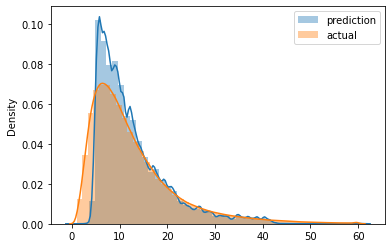

In [16]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")

plt.legend();

### Fit a lasso model

In [17]:
la = Lasso(alpha=0.01)
la.fit(X_train,y_train)

y_pred = la.predict(X_val)

mean_squared_error(y_val,y_pred, squared=False)

9.374921127169834

### Fit a ridge model

In [14]:
lg = Ridge(alpha=0.01)
lg.fit(X_train,y_train)

y_pred = lg.predict(X_val)

mean_squared_error(y_val,y_pred, squared=False)

6.007382245938421